In [1]:

import csv
import argparse
import json
import pandas as pd

# import simplejson as json
annotations_file = "../open_images/train-annotations-bbox.csv"
descriptions_file="../open_images/class-descriptions-boxable.csv"
image_map_file="marine_objs.json"
image_root = "../open_images/aerial_marine_objs"
destination_root = "."

with_small_image = True
image_key_name = 'thumbnail_300k_url'
if not with_small_image:
    image_key_name = original_url
# image_map_file="../openImageDownloader/results-20180813-230935.json"

# See notebooks/lookup_openImage_annotations.ipynb to look up specific label ID
#add ball here
labels = ['/m/0199g', '/m/019jd', '/m/019w40', '/m/04dr76w', '/m/05gqfk',
       '/m/083wq', '/m/0h9mv','']
# labels = ['/m/018xm', '/m/0199g', '/m/019jd', '/m/019w40', '/m/01h8tj',
#        '/m/01j51', '/m/04dr76w', '/m/05gqfk', '/m/07yv9', '/m/0ch_cf',
#        '/m/0fbdv', '/m/0h9mv']

image_lookup = {}

In [2]:
labeled_classes = pd.read_csv(descriptions_file,names=['label','description'])
target_labels = labeled_classes[labeled_classes['description'].isin(["Surfboard","Boat","Plastic bag", "Tire","Bottle","Bicycle","Wheel"])]
labels = target_labels['label'].values
descriptions = target_labels['description'].values
target_labels


,label,description
39,/m/0199g,Bicycle
42,/m/019jd,Boat
43,/m/019w40,Surfboard
285,/m/04dr76w,Bottle
327,/m/05gqfk,Plastic bag
408,/m/083wq,Wheel
551,/m/0h9mv,Tire


In [51]:
#make sure it's parsable
infile = open(image_map_file, 'r')
firstLine = infile.readline()
d = json.loads(firstLine)
iid = d['image_id']
# '{"image_id":"3894576d8d7f9cd1","original_url":"https://farm2.staticflickr.com/3513/3974970554_11da5a46e6_o.jpg","confidence":"1.0"}\n'

In [53]:
import os
#this would automatically dedup
def bigquery_result_to_image_lookup(image_map_file):
    image_lookup = {}
    
    with open(image_map_file, 'r',encoding='utf8') as data_file:
        json_data = data_file.read()
    
    json_str_array = json_data.split("\n")
    jsons = []
    
    for st in json_str_array:
        try:
            jsons.append(json.loads(st))
        except:
            print("failed at {}".format(len(jsons)))
#             break
    for j in jsons:
        j['filename'] = os.path.basename(j[image_key_name])    
        image_lookup[j["image_id"]] = j
    return image_lookup


In [54]:
image_lookup = bigquery_result_to_image_lookup(image_map_file)  

failed at 910557


In [55]:
len(image_lookup)

699486

In [44]:
def dedupe(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def format_annotations(annotation_path,description_table, labels, small_image=True, debug=False):
    annotations = []
    ids = []
    trainable_classes = labels
        
    with open(annotation_path) as annofile:
        reader = csv.reader(annofile)
        next(reader, None)  # skip the headers
        for row in reader:
            if row[0]=="ImageID":
                continue
            annotation = {'id': row[0], 'label': row[2], 'confidence': row[3], 'xratio0': row[4],
                          'xratio1': row[5], 'yratio0': row[6], 'yratio1': row[7]}
            if annotation['label'] in trainable_classes and annotation['id'] in image_lookup:                
                try:
                    image_filename = image_lookup[annotation['id']]['filename']
                    image_path = "{}/{}".format(image_root, image_filename)
                    pil_im = Image.open(image_path, 'r')
                    annotation['width'] = pil_im.width
                    annotation['height'] = pil_im.height
                    #keras retinanet only accepts absolute positions
                    annotation['x1'] = round(pil_im.width * float(annotation['xratio0']))
                    annotation['x2'] = round(pil_im.width * float(annotation['xratio1']))
                    annotation['y1'] = round(pil_im.height * float(annotation['yratio0']))
                    annotation['y2'] = round(pil_im.height * float(annotation['yratio1']))
                    annotation['class']= description_table[row[2]]
                    annotation['file_path'] = image_path

                    annotations.append(annotation)
                    ids.append(row[0])
                except:
                    if debug:
                        print("{} may not be available anymore".format(annotation['id']))
            
            
    ids = dedupe(ids)
    return annotations, ids

annotations, ids = format_annotations(annotations_file,description_table,labels, with_small_image)



00002f4ff380c64c may not be available anymore
00002f4ff380c64c may not be available anymore
00002f4ff380c64c may not be available anymore
00005bf623ff1ac2 may not be available anymore
00005bf623ff1ac2 may not be available anymore
00005bf623ff1ac2 may not be available anymore
00006685513e6bc4 may not be available anymore
000091f4a275d0fb may not be available anymore
0000c035a08c3770 may not be available anymore
0000dd8e0cb25756 may not be available anymore
00010417d07870a7 may not be available anymore
00010417d07870a7 may not be available anymore
00010417d07870a7 may not be available anymore
00010417d07870a7 may not be available anymore
00012db06b98f573 may not be available anymore
00012db06b98f573 may not be available anymore
00012db06b98f573 may not be available anymore
000158e3daadd0bc may not be available anymore
00019f5540822905 may not be available anymore
0001a1b43b815ec2 may not be available anymore
0001c6bf48e16ab2 may not be available anymore
0001c6bf48e16ab2 may not be availa

00274a68a11a7898 may not be available anymore
0027b41fcd4fa63d may not be available anymore
0027b41fcd4fa63d may not be available anymore
0027f5d43f2a1f95 may not be available anymore
002858f2b7394713 may not be available anymore
002858f2b7394713 may not be available anymore
00287aae94dd10b4 may not be available anymore
00287aae94dd10b4 may not be available anymore
00287aae94dd10b4 may not be available anymore
00287aae94dd10b4 may not be available anymore
00287aae94dd10b4 may not be available anymore
00287d32cad2b40d may not be available anymore
00287d32cad2b40d may not be available anymore
002893886c364be5 may not be available anymore
002893886c364be5 may not be available anymore
002893c59ac4fb8c may not be available anymore
002893c59ac4fb8c may not be available anymore
002893c59ac4fb8c may not be available anymore
002893c59ac4fb8c may not be available anymore
002893c59ac4fb8c may not be available anymore
002893c59ac4fb8c may not be available anymore
002893c59ac4fb8c may not be availa

004c104800e3536d may not be available anymore
004c104800e3536d may not be available anymore
004c90a3eee25251 may not be available anymore
004ca911b06304d3 may not be available anymore
004ca911b06304d3 may not be available anymore
004ca911b06304d3 may not be available anymore
004ca911b06304d3 may not be available anymore
004d5a59438ed934 may not be available anymore
004d5a59438ed934 may not be available anymore
004d69d2713fec19 may not be available anymore
004d906cbd115dee may not be available anymore
004d906cbd115dee may not be available anymore
004dbddc3ca4f3c0 may not be available anymore
004dcc2aa2da5651 may not be available anymore
004dcf97ec7a07ef may not be available anymore
004dcf97ec7a07ef may not be available anymore
004dd1bb774a6a89 may not be available anymore
004de04ee16194ad may not be available anymore
004de04ee16194ad may not be available anymore
004e9032ba43086b may not be available anymore
004e9032ba43086b may not be available anymore
004e9032ba43086b may not be availa

009c4cae089b3040 may not be available anymore
009c4cae089b3040 may not be available anymore
009c4cae089b3040 may not be available anymore
009c8b4e2ade1548 may not be available anymore
009c8b4e2ade1548 may not be available anymore
009c8b4e2ade1548 may not be available anymore
009c8b4e2ade1548 may not be available anymore
009d18983dca86e7 may not be available anymore
009d1c169f078c6a may not be available anymore
009d4bb6ea496154 may not be available anymore
009d4bb6ea496154 may not be available anymore
009d4bb6ea496154 may not be available anymore
009d747d204d66ff may not be available anymore
009d747d204d66ff may not be available anymore
009dddbca3ca2e11 may not be available anymore
009e4e4d77f876ef may not be available anymore
009e4e4d77f876ef may not be available anymore
009e4e4d77f876ef may not be available anymore
009e4e4d77f876ef may not be available anymore
009e4e4d77f876ef may not be available anymore
009e4e4d77f876ef may not be available anymore
009e4e4d77f876ef may not be availa

01208bd6923207db may not be available anymore
01208bd6923207db may not be available anymore
01209276c1f549e9 may not be available anymore
01209276c1f549e9 may not be available anymore
0120d7cdadafaf2c may not be available anymore
0120d7cdadafaf2c may not be available anymore
01211b9731e7535f may not be available anymore
01211b9731e7535f may not be available anymore
01216d22f62a8e3b may not be available anymore
0121c0be4ff5ad8f may not be available anymore
0121c0be4ff5ad8f may not be available anymore
012206419fe2167a may not be available anymore
012241a3bd755bf5 may not be available anymore
012241a3bd755bf5 may not be available anymore
012294b06b49e713 may not be available anymore
012294b06b49e713 may not be available anymore
0122a88bf2f1f3a7 may not be available anymore
0122a88bf2f1f3a7 may not be available anymore
0122a88bf2f1f3a7 may not be available anymore
0122a88bf2f1f3a7 may not be available anymore
0122a88bf2f1f3a7 may not be available anymore
0122a88bf2f1f3a7 may not be availa

01a8a7f5769a1e6d may not be available anymore
01a8a7f5769a1e6d may not be available anymore
01a8a7f5769a1e6d may not be available anymore
01a8a7f5769a1e6d may not be available anymore
01a9509ec2208a78 may not be available anymore
01a95e6e8126a303 may not be available anymore
01a95e6e8126a303 may not be available anymore
01a968a1d97dfacf may not be available anymore
01a968a1d97dfacf may not be available anymore
01a968a1d97dfacf may not be available anymore
01a968a1d97dfacf may not be available anymore
01a968a1d97dfacf may not be available anymore
01a968a1d97dfacf may not be available anymore
01aa3b95245433a7 may not be available anymore
01aa3f18c97e4e45 may not be available anymore
01aa3f18c97e4e45 may not be available anymore
01aa3f18c97e4e45 may not be available anymore
01aa5e1a91fa26eb may not be available anymore
01aa5e1a91fa26eb may not be available anymore
01ab12829b259070 may not be available anymore
01ab5e456723df53 may not be available anymore
01abc962f64c76b3 may not be availa

0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291b588e08e1aac may not be available anymore
0291e8bf2cbfc673 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be available anymore
0292342978c23c13 may not be availa

0312e8a3d3cba59c may not be available anymore
031358d1276defe7 may not be available anymore
0313effc014a3f70 may not be available anymore
0315b66bac391cf1 may not be available anymore
0315b66bac391cf1 may not be available anymore
0315b66bac391cf1 may not be available anymore
0315d01bcbf6dba8 may not be available anymore
031659d5fc31fea4 may not be available anymore
031659d5fc31fea4 may not be available anymore
0318e715614a2c97 may not be available anymore
03197086e32b933c may not be available anymore
03197086e32b933c may not be available anymore
03197086e32b933c may not be available anymore
03197086e32b933c may not be available anymore
0319c58f8baea6f5 may not be available anymore
0319c58f8baea6f5 may not be available anymore
031a27b0945ff483 may not be available anymore
031a27b0945ff483 may not be available anymore
031a6dbee6124336 may not be available anymore
031a84e2ec83296d may not be available anymore
031a84e2ec83296d may not be available anymore
031a84e2ec83296d may not be availa

038c3b74dc0a2893 may not be available anymore
038c3b74dc0a2893 may not be available anymore
038c99b8cebe475c may not be available anymore
038c99b8cebe475c may not be available anymore
038c99b8cebe475c may not be available anymore
038c99b8cebe475c may not be available anymore
038ec33c3856b912 may not be available anymore
038f76acf1d17f99 may not be available anymore
038f974df7993dff may not be available anymore
03909c9656c512b9 may not be available anymore
03909c9656c512b9 may not be available anymore
03909d98e8af00c2 may not be available anymore
03910d0356921632 may not be available anymore
03910d0356921632 may not be available anymore
03910d0356921632 may not be available anymore
039188638357f04e may not be available anymore
039188638357f04e may not be available anymore
039188638357f04e may not be available anymore
039188638357f04e may not be available anymore
039188638357f04e may not be available anymore
039188638357f04e may not be available anymore
039188638357f04e may not be availa

041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be available anymore
041ff66864843898 may not be availa

04e5c5622646615e may not be available anymore
04e5c5622646615e may not be available anymore
04e5c5622646615e may not be available anymore
04e5c5622646615e may not be available anymore
04e5c5622646615e may not be available anymore
04e5c5622646615e may not be available anymore
04e5c5622646615e may not be available anymore
04e60790752ee1ce may not be available anymore
04e60790752ee1ce may not be available anymore
04e60790752ee1ce may not be available anymore
04e630297d7409bf may not be available anymore
04e653d00d45dd71 may not be available anymore
04e6d1b63a6f43ca may not be available anymore
04e6d1b63a6f43ca may not be available anymore
04e74341e9820b43 may not be available anymore
04e74341e9820b43 may not be available anymore
04e7837d964e3fcc may not be available anymore
04e7af2f325e1702 may not be available anymore
04e8cd1ac2892ec2 may not be available anymore
04e8cd1ac2892ec2 may not be available anymore
04e8cd1ac2892ec2 may not be available anymore
04e8cd1ac2892ec2 may not be availa

05a8fa244653035d may not be available anymore
05a8fa244653035d may not be available anymore
05a8fa244653035d may not be available anymore
05a8fa244653035d may not be available anymore
05a8fa244653035d may not be available anymore
05a8fa244653035d may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa5f1317ce3cc0 may not be available anymore
05aa614d06984441 may not be available anymore
05aa614d06984441 may not be available anymore
05aa614d06984441 may not be available anymore
05aa614d06984441 may not be available anymore
05aa614d06984441 may not be available anymore
05aa614d06984441 may not be available anymore
05aa614d06984441 may not be availa

06434893c417b6cb may not be available anymore
06434893c417b6cb may not be available anymore
0643c649d90ad559 may not be available anymore
0643c649d90ad559 may not be available anymore
0643c649d90ad559 may not be available anymore
06462ebe9f19774f may not be available anymore
06462ebe9f19774f may not be available anymore
06462ebe9f19774f may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
064775a9ee5532ef may not be available anymore
0648166d4aea0f1e may not be available anymore
0648166d4aea0f1e may not be available anymore
06495ec363b9367f may not be available anymore
06497030a88a9db7 may not be available anymore
06497030a88a9db7 may not be availa

06e4cf5ea343281e may not be available anymore
06e4cf5ea343281e may not be available anymore
06e5b9770985946c may not be available anymore
06e5cd4751127c73 may not be available anymore
06e5cd4751127c73 may not be available anymore
06e5cd4751127c73 may not be available anymore
06e601657d0bc99b may not be available anymore
06e601657d0bc99b may not be available anymore
06e643700a87a6d7 may not be available anymore
06e643700a87a6d7 may not be available anymore
06e7c10663be09c0 may not be available anymore
06e8da3535865805 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be available anymore
06e8fd05ae8810f6 may not be availa

KeyboardInterrupt: 

In [5]:
#make sure JSON looks ok
image_lookup[iid]

{'confidence': '1.0',
 'filename': '5129964716_f9a0fafcae_o.jpg',
 'image_id': '2605846d37590468',
 'original_url': 'https://c1.staticflickr.com/2/1141/5129964716_f9a0fafcae_o.jpg'}

In [12]:
image_filename = image_lookup[iid]['filename']
# ubuntu_image_root = "/home/ubuntu/object_detection/jelly_fishes"
image_path = "{}/{}".format(image_root, image_filename)
print(image_path)

/Users/yutakahosoai/project/data/open_images/jelly_fishes/5129964716_f9a0fafcae_o.jpg


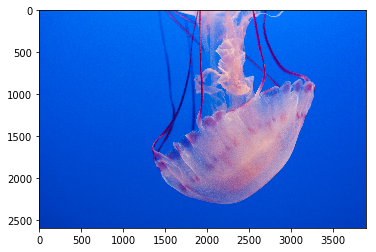

In [13]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open(image_path, 'r')
imshow(np.asarray(pil_im))

In [14]:
print(pil_im.width)
print(pil_im.height)

3888
2592


In [15]:
# description_table = {}

# with open(descriptions_file) as f:
#         for row in csv.reader(f):
#             if len(row):
#                 description_table[row[0]] = row[1].replace("\"", "").replace("'", "").replace('`', '')

In [18]:
annotations

[{'class': 'Jellyfish',
  'confidence': '1',
  'file_path': '/Users/yutakahosoai/project/data/open_images/jelly_fishes/3281616728_273cb0c3ff_o.jpg',
  'height': 1800,
  'id': '0006ac5814ed1cf3',
  'label': '/m/0d8zb',
  'width': 2400,
  'x1': 210,
  'x2': 1202,
  'xratio0': '0.087500',
  'xratio1': '0.500625',
  'y1': 0,
  'y2': 1696,
  'yratio0': '0.000000',
  'yratio1': '0.942500'},
 {'class': 'Jellyfish',
  'confidence': '1',
  'file_path': '/Users/yutakahosoai/project/data/open_images/jelly_fishes/4721232_956e582c1b_o.jpg',
  'height': 1200,
  'id': '0041410a88f2c697',
  'label': '/m/0d8zb',
  'width': 1600,
  'x1': 42,
  'x2': 849,
  'xratio0': '0.026250',
  'xratio1': '0.530625',
  'y1': 347,
  'y2': 1134,
  'yratio0': '0.289167',
  'yratio1': '0.945000'},
 {'class': 'Jellyfish',
  'confidence': '1',
  'file_path': '/Users/yutakahosoai/project/data/open_images/jelly_fishes/4721232_956e582c1b_o.jpg',
  'height': 1200,
  'id': '0041410a88f2c697',
  'label': '/m/0d8zb',
  'width': 1

In [19]:

a= annotations[0]
{ keras_key: a[keras_key] for keras_key in ['file_path', 'x1', 'y1', 'x2', 'y2', 'class'] }
keras_annotations=[]
for a in annotations:
    keras_annotations.append({ keras_key: a[keras_key] for keras_key in ['file_path', 'x1', 'y1', 'x2', 'y2', 'class'] })


In [20]:
keras_annotations[0]

{'class': 'Jellyfish',
 'file_path': '/Users/yutakahosoai/project/data/open_images/jelly_fishes/3281616728_273cb0c3ff_o.jpg',
 'x1': 210,
 'x2': 1202,
 'y1': 0,
 'y2': 1696}

In [99]:
import csv

with open("{}/annotations.csv".format(destination_root), 'w') as f: 
    w = csv.DictWriter(f, keras_annotations[0].keys())
    w.writerows(keras_annotations)

In [83]:
def process_images(saved_images_path, resized_images_path, points):
    cleaned_points = []
    for point in tqdm(points, desc="checking if images are valid from label index"):
            try:
                stored_path = os.path.join(saved_images_path, point['id'] + '.jpg')
                im = Image.open(stored_path)
                im.verify()
                # Now that the image is verified,
                # lets rescale it and overwrite.
                im.thumbnail((256, 256))
                if resized_images_path:
                    resized_path = os.path.join(resized_images_path, point['id'] + '.jpg')
                    im.save(resized_path, 'JPG')
                else:
                    os.remove(stored_path)
                    im.save(stored_path, 'JPG')
                cleaned_points.append(point)
            except:
                pass
    return cleaned_points



In [14]:
!head /Users/yutakahosoai/project/data/open_images/train-annotations-bbox.csv

ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0
000002b66c9c498e,xclick,/m/01g317,1,0.320312,0.368750,0.260938,0.328125,1,0,0,0,0
000002b66c9c498e,xclick,/m/01g317,1,0.412500,0.945312,0.120312,0.475000,1,0,1,0,0
000002b66c9c498e,xclick,/m/0284d,1,0.528125,0.923437,0.675000,0.964063,0,0,0,0,0
000002b66c9c498e,xclick,/m/04bcr3,1,0.064062,0.492188,0.889063,0.993750,0,0,0,0,0
